# Chapter 10: CLIP-Guided Diffusion

This chaper covers:

* The idea behind CLIP-guided diffusion
* Cutouts, spherical distance loss, and total variation loss
* Defining a conditioning function to guide image generation
* Creating a CLIP-guided diffusion model to generate images from text

The CLIP-guided diffusion model is a sophisticated method for generating images from textual descriptions. It combines two powerful techniques: CLIP (Contrastive Language-Image Pretraining) and diffusion models. It can generate reasonably good quality images at a slow speed by using pre-trained models. More importantly, in the next chapter, you'll see that an improved version of the CLIP-guided diffusion leads to the state of art high resolution image generation with fast speed. The idea behind CLIP-guided diffusion paves the way for the emergence of more advanced text-to-image models such as latent diffusion models and Stable Diffusion. 

You have learned how the CLIP model works in the previous chapter. CLIP is trained on a vast dataset of image-text pairs to understand and align text and images in a joint embedding space. A trained CLIP model can match images with their corresponding descriptions while distinguishing them from non-matching text descriptions. Specifically, the text encoder in CLIP uses a Transformer-based model to encode text descriptions into a high-dimensional vector space. The image encoder in CLIP uses convolutional neural networks (CNNs) to encode images into the same vector space. The goal of the CLIP model during training is to bring the image and text embeddings closer if they correspond to each other (i.e., belonging to the same image-text pair) and push them apart if they don't.

We have examined diffusion models in detail in Chapters 6 to 9. Diffusion models are generative models that reverse a gradual noise process to generate images from pure noise. In the forward diffusion process, an image is gradually noised through a series of steps until it becomes indistinguishable from pure noise. We train a denosing U-Net model to reverse this process step by step, denoising the image iteratively to transform noise back into a clean image.

In this chapter, you'll learn how to combine a pretrained CLIP model with a pretrained diffusion model to generate am image from a text description. For example, you want to generate an image using the prompt "A Van Gogh style image of an astronaut riding a unicorn." The image-generation process starts with an image that is entirely noise. The pretrained diffusion model then iteratively denoises this image. As the image is denoised, we use the pretrained CLIP model to guide this process to ensure that the denoised image matches the given text prompt.

Specifically, CLIP's text encoder processes and encodes the text prompt into a text embedding (a vector in the latent space). At each denoising step, the partially denoised image is passed through CLIP's image encoder. The resulting image embedding is compared with the text embedding. We calculate a loss function based on the similarity between the image embedding and the text embedding. The diffusion model adjusts the image to minimize this loss, guiding the image towards better alignment with the text prompt. This process is repeated over multiple denoising steps. Each step brings the generated image closer to the one that CLIP recognizes as corresponding well to the text description. After all interations are complete, you'll have a clean iamge that matches your text description. The two images below are examples of the output corresponding to the text prompt "A Vincent Van Gogh style image of an astronaut riding a unicorn." 

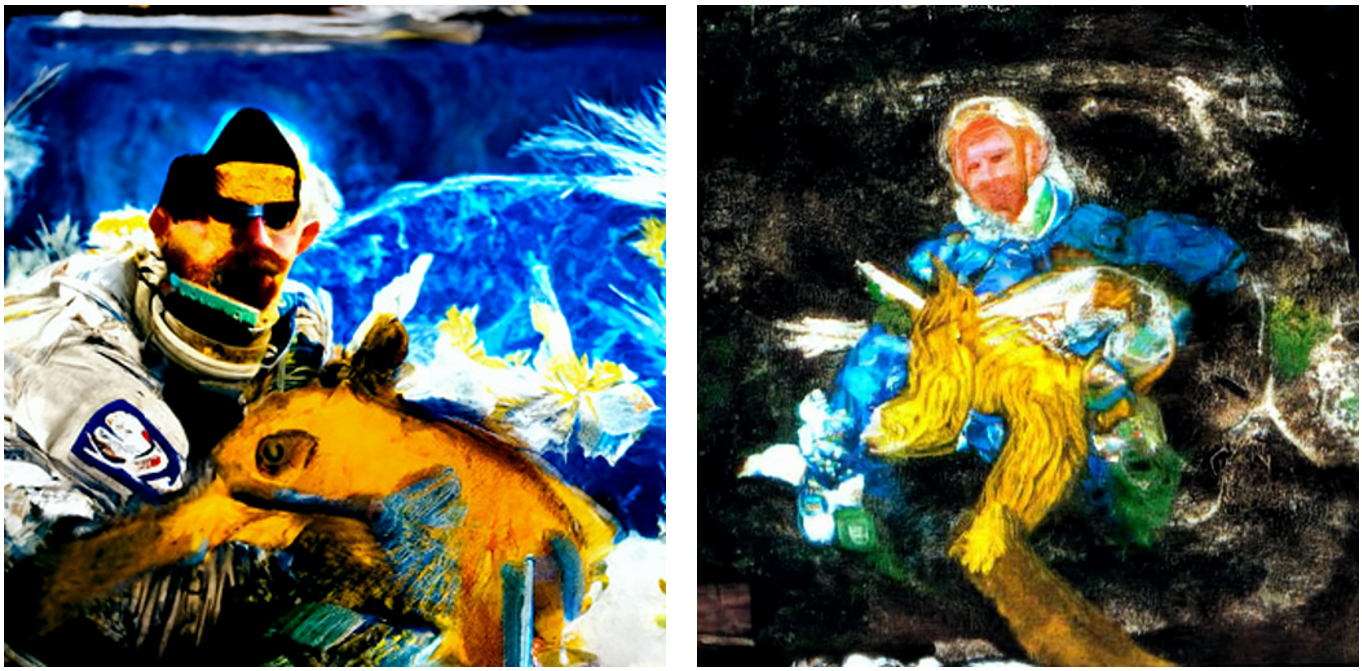

As you can see, the results roughly match the text description. You can cearly see two astronauts in the two images. More importantly, the CLIP-guided diffusion models allows researchers to improve on the method and design the state-of-the-art text-to-image Transformers such as latent diffusion models and Stable Diffusion. 

# 1. The Idea behind CLIP Guided Diffusion
In 2021, two OpenAI researchers, Prafulla Dhariwal and Alex Nichol, published a paper titled "Diffusion Models Beat GANs on Image Synthesis" (https://arxiv.org/abs/2105.05233). 
They show that diffusion models generate better quality images than the state of the art generative models, both unconditionally and conditionally. This paper lays the foundation for CLIP-guide diffusion models. 

In this section, we discuss in detail the idea behind CLIP guided diffusion models. 

## 1.1 CLIP and Diffusion Models
The CLIP-guided diffusion model uses two pretrained models: CLIP and diffusion models. Below, I'll explain the two models and what versions of the pretrained models we'll use in this chapter to create our own CLIP guided diffusion models. 

CLIP is a model developed by OpenAI, and we discussed it in detail in the previous chapter. It is a neural network that can understand and relate textual descriptions to images. It has been trained on a vast dataset of images paired with their corresponding textual descriptions. This training allows CLIP to learn a shared embedding space where both text and images are represented. In this space, similar concepts are close to each other, regardless of whether they are presented as text or images.

Specifically, a trained CLIP can embed both text and images. A pretrained CLIP model comes with a text encoder and an image encoder. These two encoders process text and images to create embeddings, which are high-dimensional vectors that represent the semantic content of the input.

CLIP is trained to bring the embeddings of matching text-image pairs closer together while pushing the embeddings of non-matching pairs apart. Therefore, we can first obtain the text embedding for the text prompts. We can then compare this embedding to the embedding of any image and measure the similarity between the text prompt and image by calculating the cosine similarity between their embeddings.

The foundational diffusion model concepts were developed by researchers such as Ho, Jain, and Abbeel in 2020, who proposed Denoising Diffusion Probabilistic Models (DDPMs). Diffusion models are a type of generative model that iteratively refine random noise into a coherent image. They are based on the concept of progressively denoising a starting image over a series of steps.

In forward diffusion, a noise scheduler adds random noise to an image step by step until it becomes pure noise. This process is reversible and each step is modeled probabilistically. A denoising U-Net model then learns to reverse the forward diffusion process. Starting from pure noise, it denoises the image step by step, gradually producing a clear image.

## 1.2 CLIP-Guided Diffusion Models
Here is the idea behind CLIP guided diffusion models. The process begins with a random noise image.

At each diffusion step, the model generates a slightly denoised version of the image. CLIP is used to guide this process by evaluating how well the intermediate images match the textual description. The diffusion model adjusts the image to improve the match. This process is repeated iteratively. The model uses the gradients from CLIP to steer the image generation process towards producing an image that closely aligns with the provided textual description.

By leveraging CLIP's ability to understand text-image relationships, the diffusion model can generate images that are highly relevant to the textual input. Diffusion models are known for producing high-quality, diverse images, making the combined approach effective for a wide range of prompts.

The integration of CLIP for guiding image generation was a novel contribution by OpenAI, enhancing the ability of generative models to produce contextually relevant and high-quality images from textual descriptions.

# 2. Spherical Distance Loss, Total Variation Loss, and Cutouts
To improve the quality of the generated images from text descriptions in CLIP guided diffusion models, we create cutouts before feeding images to the CLIP model. Further, when calculating the gradients from CLIP to steer the image generation process towards producing an image, the loss function we use is the weighted sum of Spherical Distance Loss and Total Variation Loss. 

In this section, we'll disucss the benefits of creating cutouts before feeding images to the CLIP model. We'll also explain Spherical Distance Loss and Total Variation Loss. 

## 2.1	The Benefits of Creating Cutouts
Earlier in the book when we discussed the pretrained CLIP model, we fed a color image of size 224x224 to the model to obtain the image embedding. In this chapter, when generating images using the diffusion model, at each reference time step, we'll feed an image of size 512x512 to the CLIP model to generate image embeddings to guide the image generation process. 

Rather than resizing a 512x512 image into 224x224 and feeding it to the CLIP model, we'll cut the image into 40 different 224x224 images and feed them to the CLIP model to obtain a more nuanced image embedding. 

The concept of cutouts as a data augmentation technique in deep learning was introduced by Terrance DeVries and Graham W. Taylor in their 2017 paper titled "Improved Regularization of Convolutional Neural Networks with Cutout." (https://arxiv.org/abs/1708.04552). The paper presents cutout as a simple regularization technique for convolutional neural networks that involves removing contiguous sections of the input images during training. The authors demonstrate that cutout improves the robustness and generalization of convolutional neural networks by masking out random sections of the input images during training, encouraging the network to learn more diverse and robust features.

## 2.2	How to create cutouts
To illustrate how cutouts work, let's use a bunny picure and a fish picture as examples. If you haven't already done so, download the images bunny.png and fish.png from the book's GitHub repository https://github.com/markhliu/txt2img and place it in the /files/ folder on your computer. Below, we create ten cutouts from the bunny image, as follows:

In [1]:
import torch
import torch.nn.functional as F
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# load the image and convert to tensor
im=PIL.Image.open('../Diffusion/files/bunny.png')
img=np.array(im)
img=torch.tensor(img/255).permute(2,0,1).unsqueeze(0)
cutouts = []
boxes = []
# create 6 cutouts
for _ in range (6):
    # randomly select a cutout size between 224 and 512
    size = int(torch.rand([])**0.5 * (512-224) + 224)
    # randomly select the start x and y values
    offsetx = torch.randint(0, 512 - size + 1, ())
    offsety = torch.randint(0, 512 - size + 1, ())
    # remember the coordinates of the cutout for later use
    boxes.append((offsetx, offsety, size))
    # create cutout
    cutout = img[:, :, offsety:offsety + size,
                 offsetx:offsetx + size]
    # resize to 512x512 and add to the list cutouts
    cutouts.append(F.adaptive_avg_pool2d(cutout, 512))

We first open the bunny image using the PIL library and convert the image file to a PyTorch tensor. When creating a cutout, we randomly select a cutout size between 224 (the dimension of the CLIP model inputs) and 512 (the original image dimension). We also randomly select the coordinates (offsetx, offsety) as the starting point of the cutout. We resize the cutout to 512x512 so we can plot them together later. 

We make six cutouts and plot them as follows:

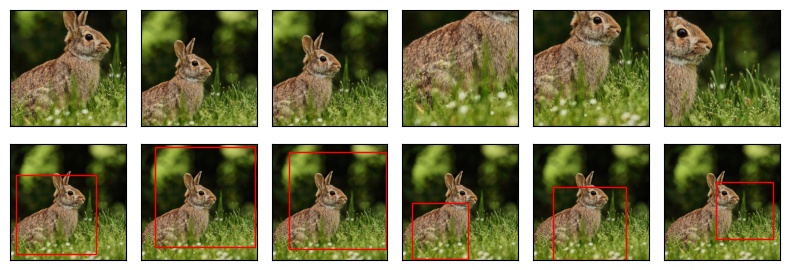

In [2]:
fig, axs = plt.subplots(nrows=2,ncols=6,sharex=True,
                        sharey=True,figsize=(8,3),dpi=100)
for col in range(6):
    axs[0, col].clear()
    axs[0, col].set_xticks([])
    axs[0, col].set_yticks([])
    # show the cutout
    axs[0, col].imshow(cutouts[col][0].permute(1,2,0))    
    axs[1, col].clear()
    axs[1, col].set_xticks([])
    axs[1, col].set_yticks([])
    # show the original image
    axs[1, col].imshow(im)
    # Create a Rectangle patch
    rect = patches.Rectangle((boxes[col][0], boxes[col][1]),
                             boxes[col][2], boxes[col][2], 
         linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    axs[1, col].add_patch(rect)
plt.tight_layout()
plt.show()

There are two rows of images in the above subplot. The top row are the six cutouts. The bottom row shows the positions of the six cutouts in the original bunny image. As you can see, the cutout has varying sizes and positions in the original image, as indicated by the red squares. 

## 2.3	Spherical Distance Loss and Total Variation Loss

Spherical distance loss is used in machine learning, particularly in computer vision and natural language processing tasks, to measure the distance between two points on a unit sphere. It is especially useful in tasks involving embeddings or feature vectors that lie on a hypersphere.

The formula for spherical distance between two vectors u and v on a unit sphere is as follows:
$$distance(u,v)=arccos(⟨u,v⟩)$$
where $⟨u,v⟩$ is the dot product of the two vectors u and v. The spherical distance loss can be used to minimize the angular distance between vectors, which is particularly useful in applications like face recognition, where the angular distance between face embeddings is used for classification. In our setting, we want to use the spherical distance loss to minimize the angular distance between the image embedding and the text embedding. Doing so makes sure that the generated image matches the text description in the prompt. 

To summary, spherical distance loss is used to minimize angular distances on a unit sphere. We'll use it to minimize the  distance between the image embedding and the text embedding to generate an image matching the text description.

Total variation loss is used primarily in image processing tasks to reduce noise while preserving edges. It is often employed in image denoising, super-resolution, and style transfer.

The total variation loss for an image I is given by:$$TV\_Loss(I)=\sum_{i,j}\sqrt{(I_{i+1,j}-I_{i,j})^2+(I_{i,j+1}-I_{i,j})^2}$$
This formula measures the differences between adjacent pixel values in both the horizontal and vertical directions. 

By minimizing the total variation loss, the goal is to produce an image with less noise and smoother regions while maintaining the sharpness of edges. This helps in generating visually appealing images with fewer artifacts.

# 3	Guidance from the CLIP Model
In this section, we discuss how the CLIP model provide guidance to the diffusion model in the text-to-image generation process. Specifically, we'll first load the pre-trained CLIP model from OpenAI. We'll then use a prompt as a concrete example and use the CLIP model to convert the text prompt into a text embedding. Finally, we'll define a conditioning function that we can use later in the diffusion model to guide the image generation. 

The Python programs in the chapter is adapted from a wonderful GitHub repository by Katherine Crowson (https://github.com/crowsonkb/clip-guided-diffusion) and two OpenAI GitHub repositories (https://github.com/openai/CLIP and https://github.com/openai/guided-diffusion). 

## 3.1 Use the CLIP Model to Encode Text Prompts
Run the following command in a code cell to clone the OpenAI GitHub repository on the CLIP model: 

In [3]:
!git clone https://github.com/openai/CLIP

After running the code cell, you should see a folder /CLIP/ on your computer. It contains all the files and modules in the CLIP model that we can use in this chapter, including encoding text and images. 

Next, we'll load a pre-trained CLIP model.

In [4]:
# access files in the CLIP folder
import sys
sys.path.append('./CLIP')
import clip

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)
# load the clip model
clip_model = clip.load('ViT-B/16', jit=False)[0]
# put the model in evaluation mode
clip_model = clip_model.eval().requires_grad_(False)
# move the mode to GPU for faster image generation
clip_model = clip_model.to(device)
# input to the CLIP model is 224x224
clip_size = clip_model.visual.input_resolution #224

Using device: cuda


The command sys.path.append('./CLIP') allows us to access files and modules in the /CLIP/ folder we just clone from GitHub. In particular, there is a load() functionn defined in the file /CLIP/clip/clip.py. We use the load() function to load the pre-trained CLIP model, version "ViT-B/16". The load() function downloads pre-trained weights from this link, https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt, and load them to the CLIP model for you to use later. 

Now that we have the pre-trained CLIP model, let's create a prompt and use CLIP to encode the text prompt into a text embedding:

In [5]:
# create a prompt
prompt='A Van Gogh style image of an astronaut riding a unicorn'
torch.manual_seed(42)
# tokenize the text
tokens = clip.tokenize(prompt).to(device)
print(tokens)
# generate text embedding
text_embed = clip_model.encode_text(tokens).float()
print("the shape of text embedding is", text_embed.shape)

tensor([[49406,   320,  2451, 19697,  1844,  2867,   539,   550, 18376,  6765,
           320, 15660, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)
the shape of text embedding is torch.Size([1, 512])


We use 'A Van Gogh style image of an astronaut riding a unicorn' as our text prompt. We first use the CLIP model to tokenize the text and convert the tokens to indexes. The above output shows that the text prompt is now 77 integers. Note the 0s are used to pad the input to a stardard size of 77 tokens long. We then feed the tokens to the CLIP model to obtain a text embedding, which has a shape of [1, 512], where 512 is the embedding dimension (each text prompt is represented by a 512-value tensor). 

## 3.2	Create A Conditioning Function
Next, we'll create a conditioning function to guide the diffusion model later. The conditioning function will take an image as input and return the negative gradient of the total loss with respect to the image. The total loss is calculated as the sum of the spherical distance loss (between the text embedding and the image embedding) and the total variation loss (of the generted image). 

Specifically, we'll first define the following make_cutouts() function:

In [6]:
from torch import nn
import torch.nn.functional as F

# define a MakeCutouts() class
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn=40, cut_pow=0.5):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        # create 40 cutouts
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size
                                   - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size,
                           offsetx:offsetx + size]
            # resize the cutouts to 224x224 
            cutouts.append(F.adaptive_avg_pool2d(cutout,
                                     self.cut_size))
        return torch.cat(cutouts)
# create a make_cutouts() functon by instantiating the class
make_cutouts = MakeCutouts(clip_size, cutn=40, cut_pow=0.5)

The make_cutouts() function will take an image of size 512x512 and randomly generate 40 cutouts, as we discussed in the previous section. For example, you can feed the fish image you downloaded before to the make_cutouts() function and obtain 40 cutouts. We then plot the 40 cutouts as follows:

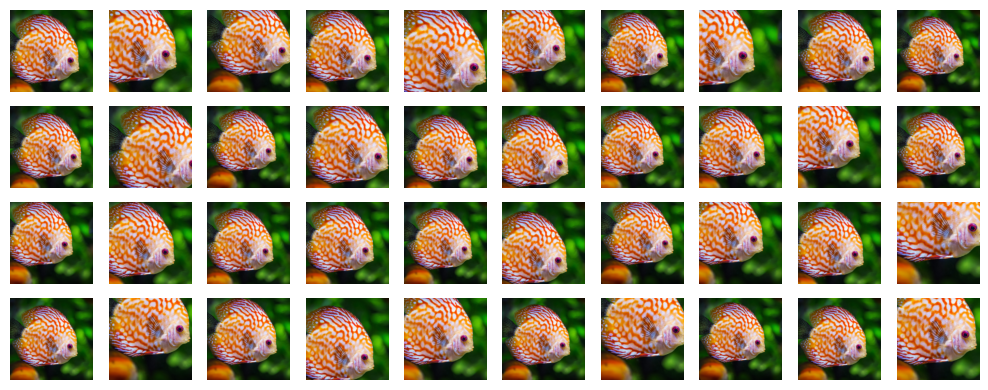

In [7]:
import PIL

# load the image and convert to tensor
im=PIL.Image.open('../Diffusion/files/fish.png')
img=np.array(im)
img=torch.tensor(img/255).permute(2,0,1).unsqueeze(0)
cutouts = make_cutouts(img)

plt.figure(figsize=(10,4),dpi=100)
for row in range(4):
    for col in range(10):
        plt.subplot(4,10,10*row+col+1)
        plt.imshow(cutouts[10*row+col].cpu().permute(1,2,0))
        plt.axis('off')
plt.tight_layout()
plt.show()

We define the spherical distance loss and total variation loss as follows:

In [8]:
def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)
def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])

The conditioning function is defined below:

In [9]:
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[0.48145466, 0.4578275, 0.40821073],
    std=[0.26862954, 0.26130258, 0.27577711])
cur_t = None
def cond_fn(x, t, y=None):
    with torch.enable_grad():
        x = x.detach().requires_grad_()
        n = x.shape[0]
        my_t = torch.ones([n], device=device, 
                          dtype=torch.long) * cur_t
        out = diffusion.p_mean_variance(model, x, my_t, 
                clip_denoised=False, model_kwargs={'y': y})
        fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
        x_in = out['pred_xstart'] * fac + x * (1 - fac)
        # make cutouts of the generated image
        clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
        # create image embedding
        image_embeds = clip_model.encode_image(\
            clip_in).float().view([cutn, n, -1])
        # spherical_dist_loss between text and image embeddings
        dists = spherical_dist_loss(image_embeds,
                                    text_embed.unsqueeze(0))
        losses = dists.mean(0)
        # total variation loss of the generation image
        tv_losses = tv_loss(x_in)
        loss = losses.sum() * clip_guidance_scale +\
        tv_losses.sum() * tv_scale
        # return the negative gradient of loss wrt image
        return -torch.autograd.grad(loss, x)[0]

The function takes an image as input and creates an image embedding. It then calculates the spherical distance loss between the image embedding and the text embedding of the prompt that the CLIP model created earlier. It also calculates the total variation loss of the image. The total loss is a weighted sum of the two losses (total variation loss and pherical distance loss). The functon returns the negative gradient of the total loss with repsect to the image. 

# 4. Image Generation with the Diffusion Model
We'll use the pre-trained diffusion model by OpenAI to generate image based on text prompts. 

In this section, you'll first clone the guided diffusion model to your computer. You'll then download the pre-trained weights from OpenAI and load the weights to the model. Finally, you'll generate an image using the conditioning functoin you created in the previous section. 

## 4.1 The Pre-Trained Guided Diffusion Model
First, run the following command in a code cell to clone the OpenAI GitHub repository on the guided diffusion model:

In [10]:
!git clone https://github.com/openai/guided-diffusion

After running the code cell, you should see a folder /guided-diffusion/ on your computer. It contains all the files and modules in the guided diffusion model that we'll use in this chapter. 

Download the pretrained weights from this link: https://openaipublic.blob.core.windows.net/diffusion/jul-2021/512x512_diffusion.pt. Place the file 512x512_diffusion.pt in the /files/ folder on your computer. 

We initiate the guide diffusion model as follows:

In [11]:
sys.path.append('./guided-diffusion')
from guided_diffusion.script_util import (
    create_model_and_diffusion,  model_and_diffusion_defaults)

model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': True,
    'diffusion_steps': 1000,
    'rescale_timesteps': True,
    'timestep_respacing': '200',  
    'image_size': 512,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})
print(model_config)
model, diffusion = create_model_and_diffusion(**model_config)

{'image_size': 512, 'num_channels': 256, 'num_res_blocks': 2, 'num_heads': 4, 'num_heads_upsample': -1, 'num_head_channels': 64, 'attention_resolutions': '32, 16, 8', 'channel_mult': '', 'dropout': 0.0, 'class_cond': True, 'use_checkpoint': False, 'use_scale_shift_norm': True, 'resblock_updown': True, 'use_fp16': True, 'use_new_attention_order': False, 'learn_sigma': True, 'diffusion_steps': 1000, 'noise_schedule': 'linear', 'timestep_respacing': '200', 'use_kl': False, 'predict_xstart': False, 'rescale_timesteps': True, 'rescale_learned_sigmas': False}


The command sys.path.append('./guided-diffusion') allows us to access files and modules in the /guided-diffusion/ folder we just clone from GitHub. In particular, we import two functions create_model_and_diffusion() and model_and_diffusion_defaults() from the file /guided-diffusion/guided-diffusion/script_util.py. 

The model_and_diffusion_defaults() function returns a dictionary of hyperparameters used in the guided diffusion model and we also update some hyperparameters. The hyperparameters we use in this chapter is shown in the above output. For example, 'image_size': 512 means the diffusion model generates color images of size 512x512; 'diffusion_steps': 1000 means there are 1000 time steps in the forward diffusion process. The hyperparameter 'timestep_respacing' controls how many reference time steps in the reverse diffusion process (i.e., image generaton process). We set it to 200, but you can change it to, say, 100, for faster image generation. There is a trade-off: more reference time steps generates high-quality images, but it takes longer. 

The model is the denoising U-Net model while diffusion is the noise scheduler. 

Note that the model is not trained. We need to load the pretrained weights before image generation, like so: 

In [12]:
model.load_state_dict(torch.load(
r'F:\txt2imgF\CLIPguidedDiffusion\512x512_diffusion.pt',
#model.load_state_dict(torch.load('files/512x512_diffusion.pt',
                                 map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

The denoising U-Net model is now loaded with pre-trained weights. We set it to the evaluation mode so the weights are frozen during the image generaton process. 

The use_fp16 hyperparameter is set as True, which means we convert all floating point weights to  float16, a 16-bit floating-point number, which provides less precise results than float32, but it takes less time to compute. There is a trade-off between precision and computational costs. Which data type to use depends on the task at hand. In our setting, since the guided diffusion model is extremely slow, using float16 helps speed up image generatoin. As a result, the image quality suffers slightly. 

## 4.2 Image Generation Based on the Text Prompt
Now we are ready to generate the image, conditional on the text embedding associated with the prompt 'A Van Gogh style image of an astronaut riding a unicorn'. 

First, let's do some preparaton work: 

In [13]:
batch_size = 1
clip_guidance_scale = 1000  
tv_scale = 150              
n_batches = 1
cutn = 40
cut_pow = 0.5

We'll use one batch and each batch contains one image to speed up image generation. The parameters clip_guidance_scale and tv_scale are the weights on the sepherical distance loss and the total variation loss when calculating the total loss.  

The generation process is as follows: 

In [14]:
import torchvision.transforms.functional as TF
# sampling function in the diffusion model
sample_fn = diffusion.p_sample_loop_progressive
cur_t = diffusion.num_timesteps - 1
# generating using the cond_fn() functon as conditioning
samples = sample_fn(model,
    (batch_size, 3, model_config['image_size'], 
     model_config['image_size']),
    clip_denoised=False,
    model_kwargs={'y': torch.zeros([batch_size],
                       device=device, dtype=torch.long)},
    cond_fn=cond_fn,
    progress=True,)

for j, sample in enumerate(samples):
    cur_t -= 1
    for k, image in enumerate(sample['pred_xstart']):
        filename = f'files/progress_{j, k}.png'
        TF.to_pil_image(image.add(1).div(2).clamp(0,
                              1)).save(filename)
        print(f'j={j}, k={k}')

The generated image is shown on the left side of figure 10.1.

The generation takes several minutes. If you want faster generation, set the 'timestep_respacing' parameter to a much lower value, say, 50. 

This chapter shows you how to use a pretrained CLIP model to guide a diffusion model to generate images based on text prompts. As you can see, the generated image starts to match the text description, though not very high quality. Further, it takes a long time to generate the image. 

However, the idea of CLIP guided diffusion is important. In the next chapter, we'll provide improvements on this model and show that by using a CLIP guided diffusion in the latent space, we can improve image quality greatly and speed up training. 